In [50]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


### Dataset Loading and Preprocessing

In [51]:
ds_path= r"animal_dataset"

classes= sorted(os.listdir(ds_path))
X=[]
y=[]

label_maps= {"cat":0, "dog":1, "panda":2}


for cls in classes:
  class_paths= os.path.join(ds_path,cls)
  
  if os.path.isdir(class_paths):
    files= sorted(os.listdir(class_paths))
    
    for file in files:
      if file.endswith(".jpg"):
        img_path= os.path.join(class_paths,file)
        gray= cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        resized= cv2.resize(gray,(32,32))
        flat_feature= resized.flatten()
        flat_feature= flat_feature.astype(np.float32)/255.0
        X.append(flat_feature)
        y.append(label_maps[cls])


features= np.array(X)
labels= np.array(y)


### K-Nearest Neighbors (KNN) Implementation

In [52]:
def KNN_for_1(train_X,train_y,test_X,K,distance_type):
  
  distance=[]
  
  for i in range(len(train_X)):
    if distance_type=="L1":
      dist= np.sum(np.absolute(test_X-train_X[i]))
    else:
      dist=  np.sqrt(np.sum((test_X-train_X[i])**2))
    distance.append(dist)
    
  
  sorted_indices= np.argsort(distance)
  k_indices= sorted_indices[:K]
  
  votes=[0,0,0]
  
  for indx in k_indices:
    label= train_y[indx]
    votes[label]+=1
  
  predicted_label=  votes.index(max(votes))
  return predicted_label




def KNN_for_all(train_X,train_y,test_X,K,distance_type):
  predictions= []
  
  for i in range(len(test_X)):
    predict= KNN_for_1(train_X,train_y,test_X[i],K,distance_type)
    predictions.append(predict)
    
  return predictions


  

### Accuracy Evaluation

In [53]:
def accuracy_calc(true_labels,predicted_labels):
  correct_prediction=0
  
  for t,p in zip(true_labels,predicted_labels):
    if t==p:
      correct_prediction+=1
  
  accuracy= (correct_prediction/len(true_labels))*100
  return accuracy


### 5-Fold Cross-Validation

In [54]:

inv_label_maps = {0: "cat", 1: "dog", 2: "panda"}

def fiveFoldCV(features, labels, K, distance_type, random_seed=42):
    
    
    np.random.seed(random_seed)
    idx = np.arange(len(features))
    np.random.shuffle(idx)
    feats = features[idx]
    labs = labels[idx]

    
    fold_size = len(feats) // 5

    accuracyFor5CV = []
    for i in range(5):
        start = i * fold_size
        end = start + fold_size

        
        test_X = feats[start:end]
        test_y = labs[start:end]

        
        train_X = np.concatenate([feats[j*fold_size:(j+1)*fold_size] for j in range(5) if j != i])
        train_y = np.concatenate([labs[j*fold_size:(j+1)*fold_size] for j in range(5) if j != i])

        
        preds = KNN_for_all(train_X, train_y, test_X, K, distance_type)
        accFor1fold = accuracy_calc(test_y, preds)
        accuracyFor5CV.append(accFor1fold)

    
    avg_accuracy = sum(accuracyFor5CV) / 5
    return avg_accuracy



### Hyperparameter Tuning (K Values)

In [56]:

K_values = [1,3,5,7,9,11,13,15,17,19]

avg_accuracy_L1 = []
avg_accuracy_L2 = []


for K in K_values:
    acc_L1 = fiveFoldCV(features, labels, K, "L1")  
    acc_L2 = fiveFoldCV(features, labels, K, "L2")
    avg_accuracy_L1.append(acc_L1)
    avg_accuracy_L2.append(acc_L2)
    print(f"K={K}  L1={acc_L1:.2f}%  L2={acc_L2:.2f}%")


print("\nL1 accuracies:", avg_accuracy_L1)
print("L2 accuracies:", avg_accuracy_L2)

K=1  L1=39.00%  L2=35.00%
K=3  L1=39.67%  L2=38.67%
K=5  L1=37.33%  L2=33.33%
K=7  L1=38.00%  L2=34.00%
K=9  L1=41.33%  L2=36.67%
K=11  L1=42.00%  L2=35.67%
K=13  L1=41.00%  L2=36.33%
K=15  L1=39.33%  L2=36.00%
K=17  L1=39.00%  L2=36.33%
K=19  L1=40.67%  L2=38.00%

L1 accuracies: [39.0, 39.66666666666667, 37.33333333333333, 38.0, 41.333333333333336, 42.0, 41.0, 39.333333333333336, 39.0, 40.666666666666664]
L2 accuracies: [35.0, 38.666666666666664, 33.33333333333333, 34.0, 36.66666666666667, 35.66666666666667, 36.333333333333336, 36.0, 36.33333333333333, 38.0]


### Plot: K vs Accuracy (L1 vs L2)

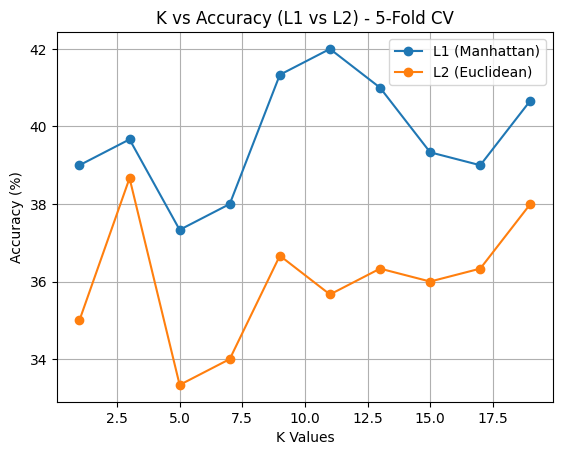

In [57]:

plt.figure()
plt.plot(K_values, avg_accuracy_L1, marker='o', label="L1 (Manhattan)")
plt.plot(K_values, avg_accuracy_L2, marker='o', label="L2 (Euclidean)")
plt.xlabel("K Values")
plt.ylabel("Accuracy (%)")
plt.title("K vs Accuracy (L1 vs L2) - 5-Fold CV")
plt.legend()
plt.grid(True)
plt.show()





### Top 5 Predictions


Using best K for L1 (based on CV): 11

Top 5 Predictions (from selected random 5 images):
Image idx 262  True = panda  Predicted = dog
Image idx 114  True = dog  Predicted = cat
Image idx 165  True = dog  Predicted = dog
Image idx 278  True = panda  Predicted = cat
Image idx 293  True = panda  Predicted = dog


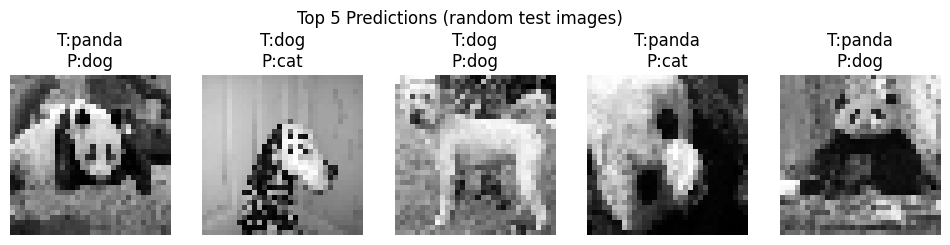

In [58]:
np.random.seed(123)
test_indices = np.random.choice(len(features), size=5, replace=False)

mask = np.ones(len(features), dtype=bool)
mask[test_indices] = False
train_X = features[mask]
train_y = labels[mask]
test_X = features[test_indices]
test_y = labels[test_indices]

best_idx_L1 = int(np.argmax(avg_accuracy_L1))
best_K_L1 = K_values[best_idx_L1]
print("\nUsing best K for L1 (based on CV):", best_K_L1)

preds_top5 = KNN_for_all(train_X, train_y, test_X, best_K_L1, "L1")

print("\nTop 5 Predictions (from selected random 5 images):")
for i, idx in enumerate(test_indices):
    true_lab = test_y[i]
    pred_lab = preds_top5[i]
    print(f"Image idx {int(idx)}  True = {inv_label_maps[int(true_lab)]}  Predicted = {inv_label_maps[int(pred_lab)]}")

plt.figure(figsize=(12,3))
for i in range(5):
    img = (test_X[i].reshape(32,32) * 255).astype(np.uint8)
    plt.subplot(1,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T:{inv_label_maps[int(test_y[i])]}\nP:{inv_label_maps[int(preds_top5[i])]}")
    plt.axis('off')
plt.suptitle("Top 5 Predictions (random test images)")
plt.show()

### Discussion

Based on the 5-fold cross-validation results, Manhattan (L1) distance performs better than Euclidean (L2) distance for this gray-scale image dataset. The average accuracy for L1 reached 42% at K = 11, while the highest for L2 was around 38.67% at K = 3. This shows that L1 distance gives more reliable predictions for these images.

The dataset has three classes (cat, dog, panda), and the images are small (32x32) with gray-scale pixels. L1 distance measures absolute differences between pixels, which makes it less sensitive to small variations in pixel intensity. L2 distance squares the differences, which can exaggerate small changes and sometimes reduce accuracy.

Looking at the top 5 predictions, some images are misclassified. For example, pandas were predicted as dogs or cats. This happens because the images are small, features overlap between classes, and KNN is a simple model that cannot handle complex patterns.

To improve accuracy, we could:

* Use larger images or extract better features instead of raw pixels.
* Try other distance metrics or weighted KNN.
* Use a more advanced classifier like SVM or a simple neural network.

In conclusion, for this dataset,  distance with K = 11 is better than L2, but the overall accuracy is limited by image size, feature simplicity, and the basic nature of KNN.

